In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wget

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
filename = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
file = wget.download(filename)
print(file)

100% [..........................................................................] 1475504 / 1475504

data (2).csv


In [3]:
data = pd.read_csv('data.csv')
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)

for c in categorical_columns:
    data[c] = data[c].str.lower().str.replace(' ', '_') 
    
df_new = data[['make', 'model', 'year', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'msrp']]

df = df_new.fillna(0)

In [5]:
df['price'] = df.msrp
del df['msrp']

In [6]:
def price_binary(df, price): 
    price_mean = df['price'].mean()
    df['above_average_' + price] = (df[price] >= price_mean).astype(int)
    return df

In [7]:
df = price_binary(df.copy(), 'price')
del df['price']

In [8]:
from sklearn.model_selection import train_test_split

df_fulltrain, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_fulltrain, test_size=0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_train = df_train.above_average_price.values
y_val = df_val.above_average_price.values
y_test = df_test.above_average_price.values

In [11]:
del df_train['above_average_price']
del df_val['above_average_price']
del df_test['above_average_price']

In [12]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']

In [15]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%16s, %.3f' % (c, auc))

            year, 0.688
       engine_hp, 0.917
engine_cylinders, 0.766
     highway_mpg, 0.633
        city_mpg, 0.673


In [16]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [17]:
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9761329930330412

In [42]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.arange(0, 1, 0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        scores.append((t, tp, fp, fn, tn, p, r))
    columns = ['threshold', 'tp', 'fp', 'fn',r'tn','p', 'r']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [43]:
df_all_scores = tpr_fpr_dataframe(y_val, y_pred)
df_all_scores

,threshold,tp,fp,fn,tn,p,r,tpr,fpr
0,0.00,654,1729,0,0,0.274444,1.000000,1.000000,1.000000
1,0.01,652,854,2,875,0.432935,0.996942,0.996942,0.493927
2,0.02,651,702,3,1027,0.481153,0.995413,0.995413,0.406015
3,0.03,651,618,3,1111,0.513002,0.995413,0.995413,0.357432
4,0.04,650,559,4,1170,0.537634,0.993884,0.993884,0.323308
...,...,...,...,...,...,...,...,...,...
95,0.95,274,1,380,1728,0.996364,0.418960,0.418960,0.000578
96,0.96,254,1,400,1728,0.996078,0.388379,0.388379,0.000578
97,0.97,241,0,413,1729,1.000000,0.368502,0.368502,0.000000
98,0.98,217,0,437,1729,1.000000,0.331804,0.331804,0.000000


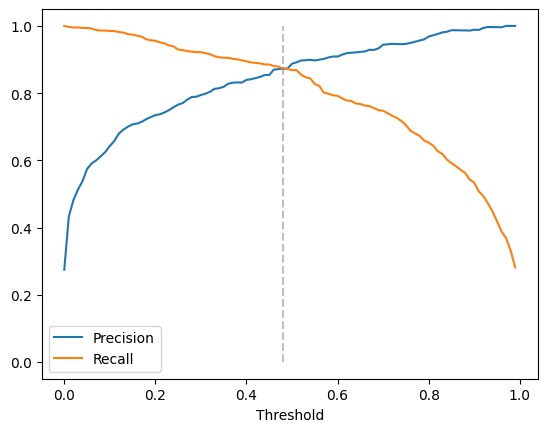

In [44]:
plt.plot(df_all_scores.threshold, df_all_scores['p'], label='Precision')
plt.plot(df_all_scores.threshold, df_all_scores['r'], label='Recall')
plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.xlabel('Threshold')
plt.legend()

In [50]:
df_all_scores['F1'] = 2 * df_all_scores.p * df_all_scores.r / (df_all_scores.p + df_all_scores.r)

In [51]:
df_all_scores.loc[df_all_scores.F1.argmax()]

threshold       0.510000
tp            568.000000
fp             69.000000
fn             86.000000
tn           1660.000000
p               0.891680
r               0.868502
tpr             0.868502
fpr             0.039907
F1              0.879938
Name: 51, dtype: float64

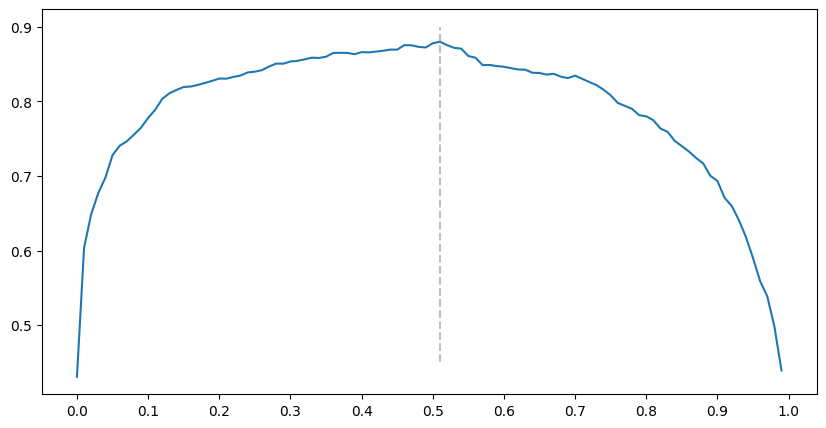

In [53]:
plt.figure(figsize=(10, 5))

plt.plot(df_all_scores.threshold, df_all_scores.F1)
plt.vlines(0.51, 0.45, 0.9, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [54]:
from sklearn.model_selection import KFold

In [57]:
columns = list(df.columns)
columns.remove('above_average_price')
columns

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [58]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [61]:
from tqdm.auto import tqdm

In [62]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in tqdm(kfold.split(df_fulltrain)):
    df_train = df_fulltrain.iloc[train_idx]
    df_val = df_fulltrain.iloc[val_idx]

    y_train = df_train.above_average_price.values
    y_val = df_val.above_average_price.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]C:\Users\CGX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
1it [00:12, 12.36s/it]C:\Users\CGX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternat

0.979 +- 0.002


In [67]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    for train_idx, val_idx in tqdm(kfold.split(df_fulltrain)):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]

        y_train = df_train.above_average_price.values
        y_val = df_val.above_average_price.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(C, '%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

5it [00:09,  1.84s/it]


0.01 0.952 +- 0.002


5it [00:38,  7.71s/it]


0.1 0.972 +- 0.002


0it [00:00, ?it/s]C:\Users\CGX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
1it [00:12, 12.50s/it]C:\Users\CGX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternat

0.5 0.979 +- 0.003


0it [00:00, ?it/s]C:\Users\CGX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
1it [00:12, 12.41s/it]C:\Users\CGX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternat

10 0.980 +- 0.003
